# Датасет Moons

In [ ]:
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

import warnings
warnings.filterwarnings('ignore', 'FutureWarning')

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
RANDOM_STATE = 42

In [ ]:
X, y = make_moons(n_samples=10000, random_state=RANDOM_STATE, noise=.1)

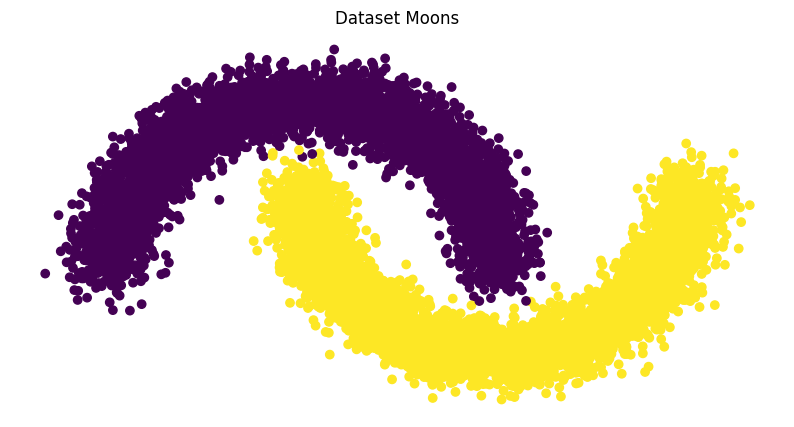

In [ ]:
plt.figure(figsize=(10, 5))
plt.title('Dataset Moons')
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis')
plt.axis('off')
plt.show()

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=RANDOM_STATE)

In [ ]:
X_train_t = torch.from_numpy(X_train).to(torch.float32)
y_train_t = torch.from_numpy(y_train).type_as(X_train_t)
X_val_t = torch.from_numpy(X_val).to(torch.float32)
y_val_t = torch.from_numpy(y_val).type_as(X_val_t)

In [ ]:
BATCH = 128

train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH)

In [ ]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(in_features, out_features), requires_grad=True)
        self.bias = bias
        if self.bias:
            self.bias_term = nn.Parameter(torch.ones(out_features))

    def forward(self, x):
        x = x @ self.weights
        if self.bias:
            x += self.bias_term
        return x

In [ ]:
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=.05)

linear_regression = linear_regression.to()

In [ ]:
TOL = 1e-3
MAX_EPOCHS = 100
losses = []
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False

for epoch in range(MAX_EPOCHS):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        linear_regression.train()
        optimizer.zero_grad()
        outp = linear_regression(X_batch)
        outp = outp.flatten()
        loss = loss_function(outp, y_batch)
        loss.backward()
        losses.append(loss.detach().cpu().numpy().item())
        optimizer.step()
        probabilities = 1 / (1 + (-1 * outp).exp())
        preds = (probabilities > .5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)

        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f'Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}')
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < TOL:
            print(f"\nIteration: {it + epoch * len(train_dataloader)}. Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

Iteration: 0
Batch accuracy: 0.4453125
Iteration: 100
Batch accuracy: 0.8046875
Iteration: 200
Batch accuracy: 0.8125
Iteration: 300
Batch accuracy: 0.90625
Iteration: 400
Batch accuracy: 0.890625
Iteration: 500
Batch accuracy: 0.8984375
Iteration: 600
Batch accuracy: 0.859375
Iteration: 700
Batch accuracy: 0.828125
Iteration: 800
Batch accuracy: 0.84375

Iteration: 814. Convergence. Stopping iterations.


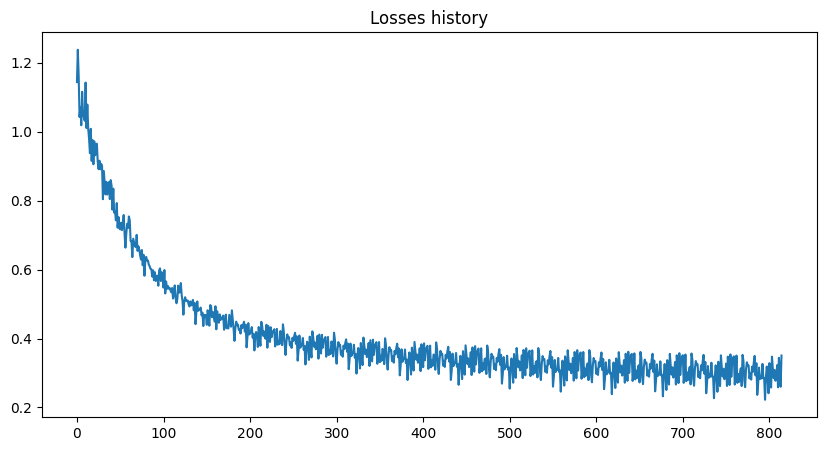

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.title('Losses history')
plt.show()

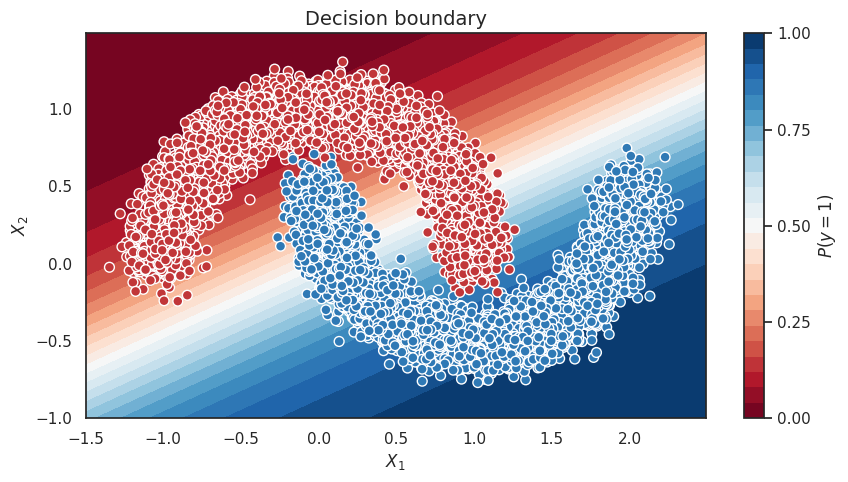

In [ ]:
sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(10, 5))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

In [ ]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        outp = model.forward(x_batch)
        preds = 1 / (1 + (-1 * outp).exp())
        preds = preds >= 0.5
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    return predictions.flatten()

In [ ]:
from sklearn.metrics import accuracy_score

accuracy_score(predict(val_dataloader, linear_regression), y_val)

0.8664

# Датасет MNIST

In [ ]:
import os
from torchvision.datasets import MNIST
from torchvision import transforms as tfs

BATCH = 128

data_tfs = tfs.Compose([tfs.ToTensor(), tfs.Normalize((.5), (.5))])

root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH)
valid_dataloader = DataLoader(val_dataset, batch_size=BATCH)

In [ ]:
def test_activation_function(activation):
    input_size = 784
    hidden_size = 128
    output_size = 10
    MAX_EPOCHS = 10

    model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(input_size, hidden_size),
        activation,
        nn.Linear(hidden_size, output_size),
        activation,
        nn.Linear(output_size, output_size)).to(DEVICE)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())

    loaders = {"train": train_dataloader, "valid": valid_dataloader}
    accuracy = {"train": [], "valid": []}

    for epoch in range(MAX_EPOCHS):
        for k, dataloader in loaders.items():
            epoch_correct = 0
            epoch_all = 0
            for x_batch, y_batch in dataloader:
                if k == "train":
                    model.train()
                    optimizer.zero_grad()
                    outp = model(x_batch.to(DEVICE))
                else:
                    model.eval()
                    outp = model(x_batch.to(DEVICE))

                preds = outp.argmax(-1)
                correct = torch.sum(preds == y_batch.to(DEVICE))
                all = BATCH
                epoch_correct += correct.item()
                epoch_all += all
                if k == "train":
                    loss = criterion(outp, y_batch.to(DEVICE))
                    loss.backward()
                    optimizer.step()
            if k == "train":
                print(f"Epoch: {epoch+1}")
            print(f'Loader: {k}. Accuracy: {epoch_correct/epoch_all}')
            accuracy[k].append(epoch_correct/epoch_all)
    return accuracy['valid']

In [ ]:
class Identical(nn.Module):
    def forward(self, x):
        return x

In [ ]:
relu_accuracy = test_activation_function(nn.ReLU())
elu_accuracy = test_activation_function(nn.ELU())
leaky_relu_accuracy = test_activation_function(nn.LeakyReLU())
identical_accuracy = test_activation_function(Identical())

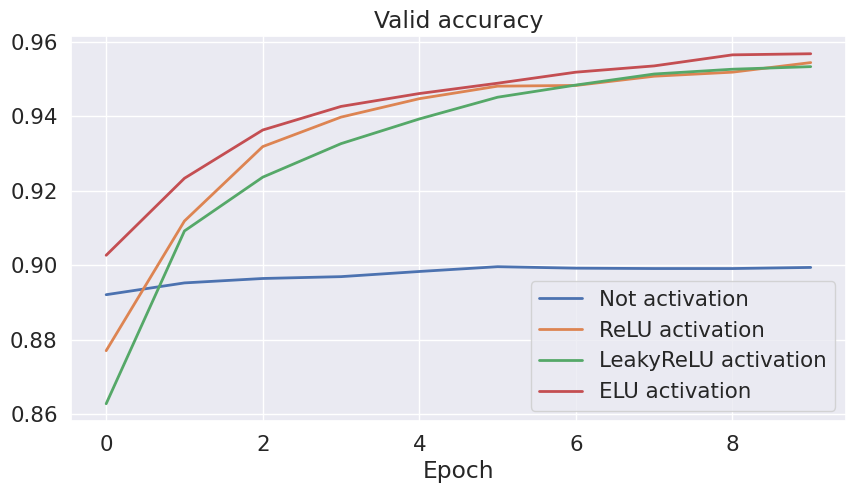

In [ ]:
sns.set(style="darkgrid", font_scale=1.4)

MAX_EPOCHS = 10

plt.figure(figsize=(10, 5))
plt.title("Valid accuracy")
plt.plot(range(MAX_EPOCHS), identical_accuracy, label="Not activation", linewidth=2)
plt.plot(range(MAX_EPOCHS), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(MAX_EPOCHS), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(MAX_EPOCHS), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

Лучше всего себя показала ELU

# Сверточные NN

In [ ]:
!wget https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg -O sample_photo.jpg

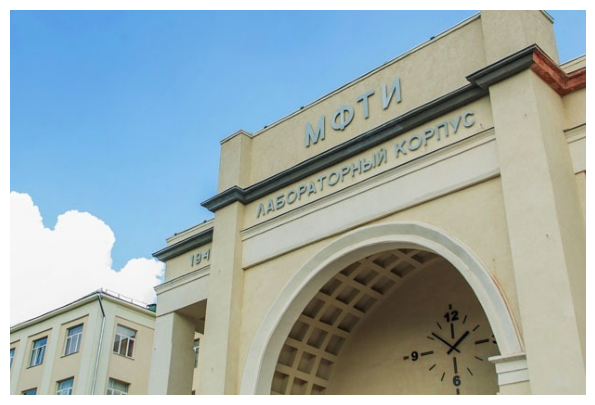

In [ ]:
import cv2
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 5))
plt.imshow(RGB_img)
plt.axis('off')
plt.show()

In [ ]:
kernels = [
    [[0, 0, 0],
    [0, 1, 0],
    [0, 0, 0]],

    [[0, 1, 0],
    [0, -2, 0],
    [0, 1, 0]],

    [[0, 0, 0],
    [1, -2, 1],
    [0, 0, 0]],

    [[0, 1, 0],
    [1, -4, 1],
    [0, 1, 0]],

    [[0, -1, 0],
    [-1, 5, -1],
    [0, -1, 0]],

    [[0.0625, 0.125, 0.0625],
    [0.125, 0.25, 0.125],
    [0.0625, 0.125, 0.0625]]
]

titles = ['Тождественное преобразование',
          'Выделение горизонтальных границ',
          'Выделение вертикальных границ',
          'Выделение границ',
          'Увеличение резкости',
          'Размытие']

<Figure size 1200x400 with 0 Axes>

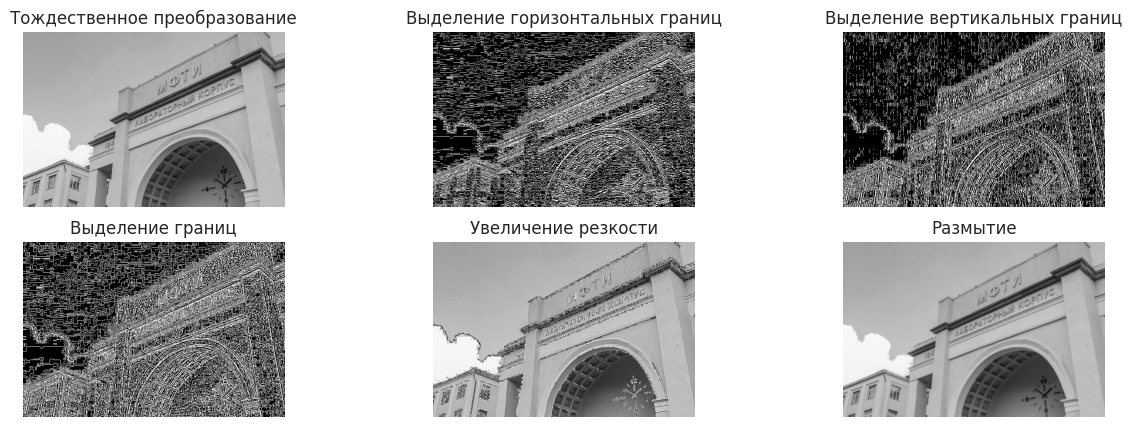

In [ ]:
plt.figure(figsize=(12, 4))

fig, axes = plt.subplots(2, 3, figsize=(15, 5))

row_index = 0
col_index = 0

for i, kernel in enumerate(kernels):

    img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
    kernel = torch.tensor(kernel).reshape(1, 1, 3, 3).type(torch.float32)
    kernel = kernel.repeat(3, 3, 1, 1)
    img_t = img_t.permute(0, 3, 1, 2)
    img_t = nn.ReflectionPad2d(1)(img_t)
    result = F.conv2d(img_t, kernel)[0]
    result_np = result.permute(1, 2, 0).numpy() / 256 / 3
    axes[row_index, col_index].set_title(titles[i])
    axes[row_index, col_index].imshow((result_np * 256).astype(np.uint8))
    axes[row_index, col_index].axis('off')

    if col_index == 2:
        col_index = 0
        row_index += 1
    else:
        col_index += 1

In [ ]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(400, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.relu = F.relu
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

In [ ]:
model = LeNet().to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [ ]:
accuracy = {"train": [], "valid": []}
MAX_EPOCHS = 10

for epoch in range(MAX_EPOCHS):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                model.train()
                optimizer.zero_grad()
                outp = model(x_batch.to(DEVICE))
            else:
                model.eval()
                outp = model(x_batch.to(DEVICE))

            preds = outp.argmax(-1)
            correct = torch.sum(preds == y_batch.to(DEVICE))
            all = BATCH
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch.to(DEVICE))
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f'Loader: {k}. Accuracy: {epoch_correct/epoch_all}')
        accuracy[k].append(epoch_correct/epoch_all)

In [ ]:
lenet_accuracy = accuracy["valid"]

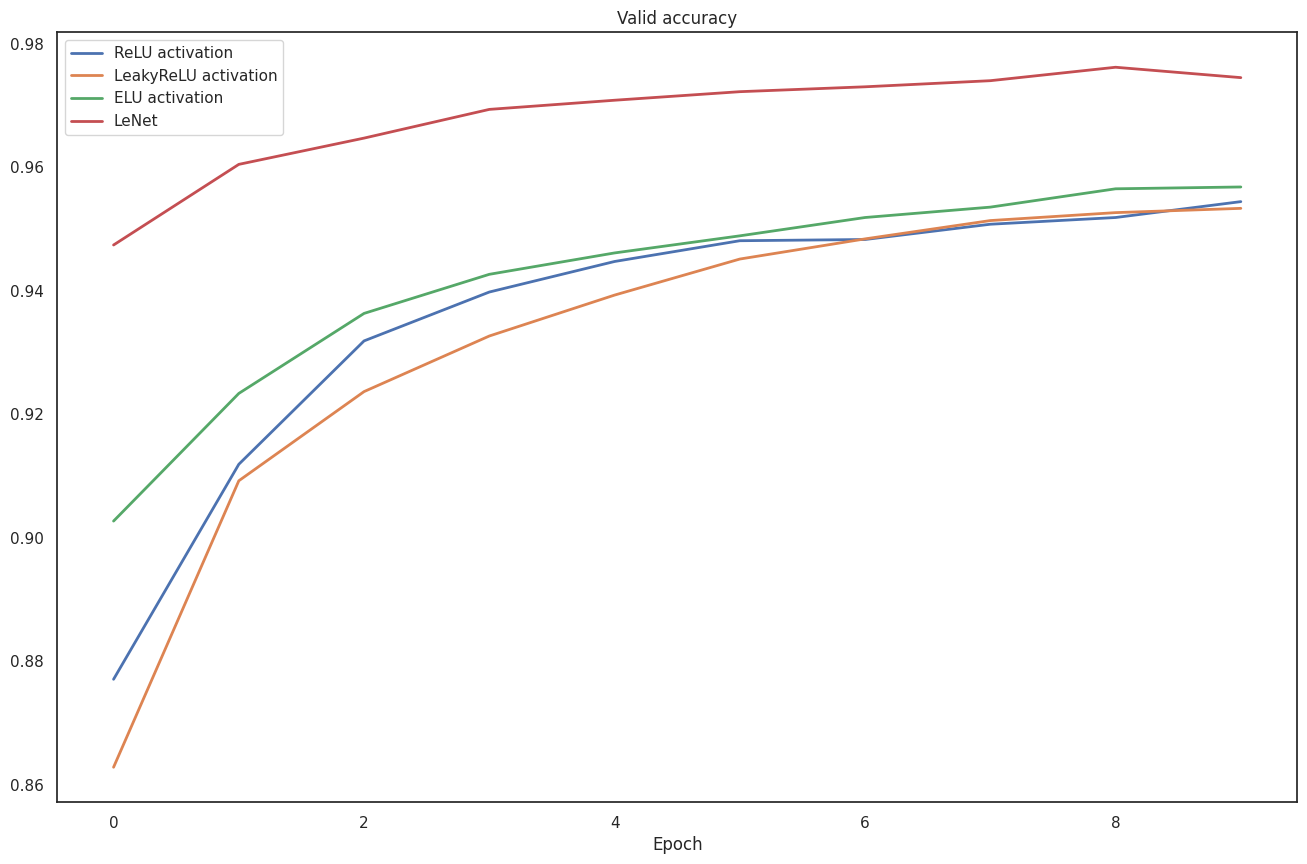

In [ ]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(MAX_EPOCHS), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(MAX_EPOCHS), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(MAX_EPOCHS), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(MAX_EPOCHS), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

In [ ]:
round(lenet_accuracy[-1], 2)

0.97